## 5.3 Using a pretrained Convnet

(1) 케라스 창시자에게 배우는 딥러닝 도서의 실습 코드 입니다. <br><br>
(2) 코드를 이해한 후, 각 입력창 마다 주석을 추가해 보았습니다. <br><br>
(3) 필요 시 입력 창을 Add 하여 내용을 추가하였습니다.  <br><br>
(4) 번역자의 원 코드가 있는 Github URL은 아래와 같습니다. <br><br>
https://github.com/rickiepark/deep-learning-with-python-notebooks

In [7]:
import keras
keras.__version__

'2.3.1'

In [8]:
# 기존처럼 직접 생성한 Convnet을 사용하지 않고, 기 구현되어 있는 사전에 훈련된 CNN을 이용
# VGG16 (2014년 ILSVRC 2위) Model을 이용하고, 다음과 같이 parameter setup
#  (1) weight : Model을 초기화 할 가중치 Checkpoint
#  (2) include_type : Network를 하위(CNN) 계층과 상위(Fully Connected Network) 계층으로 구분 시, 상위 계층도 Network에 포함시킬지 선택 (True : 포함, False : 미포함)
# (3) input_shape : Network에 주입할 Image 텐서의 크기 (150 * 150 * 3 dog or cat image를 사용하고 있으므로, (150, 150, 3) 으로 지정)

from keras.applications import VGG16
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [9]:
# VGG16 Convnet
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### ※ VGG16 image (Original Image인 224 * 224 * 3 의 경우)
![title](./image/VGG16.jpg)

(1) CNN Layer의 최종 Feature Map의 크기는 `(4 * 4 * 512)` 이고 Fully Connected Layer를 추가로 연결해야 함

(2) 이때, 다음과 같은 두 가지 방식이 가능

ⓐ 방법 1
- 새로운 Dataset 에서 CNN Layer를 실행하고, 해당 출력을 Numpy 배열로 저장하여, Fully Connected Layer에 입력으로 사용
- 모든 입력 이미지에 CNN Layer를 한 번만 실행하면 되므로 속도가 빠르나, Data Augmentation을 사용할 수 없음

ⓑ 방법2
 - CNN Layer에 Fully Connected Layer를 쌓아 먼저 확장하고, 모든 입력 image에 전체 Model을 실행
 - 모든 입력 image가 CNN Layer를 통하게 되므로, Data Augmentation을 사용할 수 있으나 방법1에 비해 시간과 비용이 많이 소요 됨

## 방법 1
### 새로운 Dataset 에서 CNN Layer를 실행하고, 해당 출력을 Numpy 배열로 저장하여, Fully Connected Layer에 입력으로 사용
### 모든 입력 이미지에 CNN Layer를 한 번만 실행하면 되므로 속도가 빠르나, Data Augmentation을 사용할 수 없음

In [10]:
# conv_base의 predict method를 호출하여 image에서 특성을 추출
# 즉, 2000개의 train image에 대하여 VGG16 model을 통해 특성을 추출
#        1000개의 validation image에 대하여 VGG16 model을 통해 특성을 추출
#        1000개의 test image에 대하여 VGG16 model을 통해 특성을 추출

import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './image/datasets/cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # loop 안에서 무한하게 data를 생성하므로, 기준을 정해 중지 시킴
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.

Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# 추출된 Feature를 Fully Connected Network에 주입하기 위해 Flatten 작업 진행 (sample 갯수, 4 * 4 * 512 = 8192)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [6]:
# Fully Connected Network를 정의 하고, overfitting을 최소화 하기 위해 dropout을 사용
# feature와 label을 이용하여 training을 진행
# 해당 training은 2개의 Fully Connected Network만 처리하므로, CPU 만으로도 빠른 속도를 기대 할 수 있음

from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 391us/step - loss: 0.6087 - acc: 0.6615 - val_loss: 0.4414 - val_acc: 0.8170
Epoch 2/30
2000/2000 [==============================] - 1s 321us/step - loss: 0.4372 - acc: 0.7990 - val_loss: 0.3574 - val_acc: 0.8680
Epoch 3/30
2000/2000 [==============================] - 1s 319us/step - loss: 0.3506 - acc: 0.8530 - val_loss: 0.3180 - val_acc: 0.8890
Epoch 4/30
2000/2000 [==============================] - 1s 320us/step - loss: 0.3105 - acc: 0.8730 - val_loss: 0.2963 - val_acc: 0.8920
Epoch 5/30
2000/2000 [==============================] - 1s 317us/step - loss: 0.2805 - acc: 0.8865 - val_loss: 0.2794 - val_acc: 0.8990
Epoch 6/30
2000/2000 [==============================] - 1s 318us/step - loss: 0.2638 - acc: 0.8960 - val_loss: 0.2688 - val_acc: 0.9010
Epoch 7/30
2000/2000 [====================

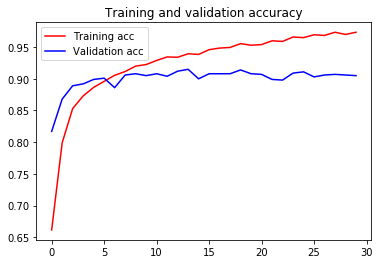

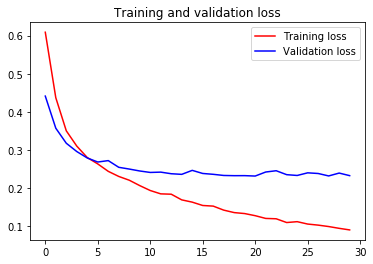

In [8]:
# Validation Accuracy가 약 90%로, 앞에서 직접 훈련시킨 Model에 비하여 상당히 높은 Accuracy를 보이고 있음
# 다만 Dataset의 갯수가 적은 관계로, dropout을 수행하였음에도 Training Accuracy를 따라가지 못하고 정체됨
# 즉, 비교적 빨리 overfitting이 일어나는 것을 볼 수 있음

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## 방법 2
 ### CNN Layer에 Fully Connected Layer를 쌓아 먼저 확장하고, 모든 입력 image에 전체 Model을 실행
 ### 모든 입력 image가 CNN Layer를 통하게 되므로, Data Augmentation을 사용할 수 있으나 방법1에 비해 시간과 비용이 많이 소요 됨

In [9]:
from keras import models
from keras import layers

# VGG model에 Flatten, Fully Connected Layer를 먼저 쌓음
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Model을 training, compile 하기 전에 conv_base를 동결하여 가중치가 update 되지 않도록 막아야 함
# 그래야 conv_base에서 사전에 학습한 표현(representation)의 임의 수정을 막을 수 있음

print('conv_base를 동결하기 전 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30


In [12]:
# conv_base를 동결하여 가중치가 update 되지 않도록 함
conv_base.trainable = False

In [13]:
# Fully Connected Network의 가중치만 훈련됨 (2개 층의 가중치 행렬과 Bias가 각각 훈련되므로, 총 4개의 가중치가 훈련 됨)
print('conv_base를 동결한 후 훈련되는 가중치의 수:', 
      len(model.trainable_weights))

conv_base를 동결한 후 훈련되는 가중치의 수: 4


In [14]:
from keras.preprocessing.image import ImageDataGenerator

# Data 증식을 수행 
# rotation_range : image를 random하게 회전시키는 각도 (0 ~ 180)
# width_shift_range : image를 수평으로 ramdom 하게 평행이동 시키는 범위 (전체 넓이와 폭에 대한 비율)
# height_shift_range : image를 수직으로 ramdom 하게 평행이동 시키는 범위 (전체 넓이와 높이에 대한 비율)
# shear_range : image를 ramdom하게 전단(shear) 변환을 적용할 각도 범위
# zoom_range : image를 ramdom 하게 확대할 범위
# horizontal_flip : image를 ramdom 하게 수평으로 뒤집기
# fill_mode : rotation, shift 등으로 새롭게 생성해야 할 fixel을 어떻게 생성할 것인지 명시  ("constant", "nearest", "reflect" or "wrap")
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

# 검증 데이터는 증식하지 않음
test_datagen = ImageDataGenerator(rescale=1./255)

# Training Data에 대하여 150*150 행렬로 변환하고, class_mode는 이진분류를 사용한 generator 생성
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

# Validation Data에 대하여 150*150 행렬로 변환하고, class_mode는 이진분류를 사용한 generator 생성
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

# compile method를 이용하여 학습 과정을 구성
# 옵티마이저는 rmsprop를 사용하고, 이진 분류 문제이므로 손실함수는 binary_crossentropy를 이용
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

# fit method를 이용해서 정해진 epoch 만큼  Training을 수행
# 이때 위에서 재 정의한 image, label을 주입하고, batch size를 지정
# 기존에는 fit method를 이용하여 정해진 epoch 만큼 Training을 수행하였으나, 금번에는 fit_generator method를 이용
# 해당 method는 python의  generator를 이용하므로, steps_per_epoch에서 추출할 sample 갯수를 지정해야 함 (100개)
# 30번의 epoch 동안 반복하여 training을 수행하고, validation_data parameter도 함께 전달하여 loss와 accuracy를 평가
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50, verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 46s - loss: 0.5586 - acc: 0.7360 - val_loss: 0.3442 - val_acc: 0.8340
Epoch 2/30
 - 47s - loss: 0.4158 - acc: 0.8275 - val_loss: 0.3335 - val_acc: 0.8570
Epoch 3/30
 - 47s - loss: 0.3588 - acc: 0.8540 - val_loss: 0.2708 - val_acc: 0.8790
Epoch 4/30
 - 47s - loss: 0.3251 - acc: 0.8680 - val_loss: 0.1967 - val_acc: 0.8840
Epoch 5/30
 - 47s - loss: 0.3066 - acc: 0.8740 - val_loss: 0.1960 - val_acc: 0.8900
Epoch 6/30
 - 47s - loss: 0.2845 - acc: 0.8910 - val_loss: 0.2698 - val_acc: 0.8940
Epoch 7/30
 - 47s - loss: 0.2797 - acc: 0.8790 - val_loss: 0.2673 - val_acc: 0.8940
Epoch 8/30
 - 47s - loss: 0.2640 - acc: 0.8935 - val_loss: 0.2383 - val_acc: 0.8930
Epoch 9/30
 - 47s - loss: 0.2548 - acc: 0.8980 - val_loss: 0.2228 - val_acc: 0.9050
Epoch 10/30
 - 47s - loss: 0.2488 - acc: 0.8960 - val_loss: 0.1688 - val_acc: 0.8970
Epoch 11/30
 - 47s - loss: 0.2433 - acc: 0.8990 - val_loss: 0.2175 - val_ac

In [15]:
# Training이 끝난 모델을 저장하여 필요 시 재 사용
model.save('cats_and_dogs_small_3.h5')

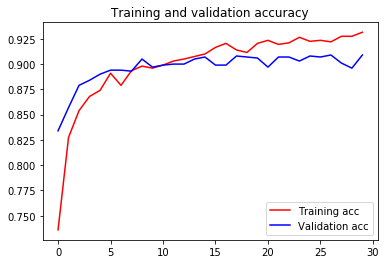

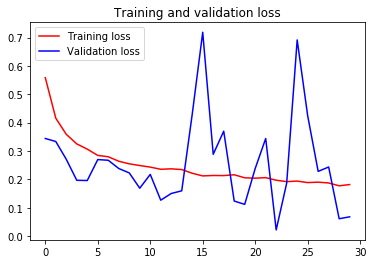

In [16]:
# Training Data와 Validation Data에 대한 Model의 Loss와 Accuracy를 그래프로 확인

# (1) Accuracy
# Data 증식 이전과 Accuracy는 거의 비슷하나, Validation Data의 기울기가 좀 더  큰 것으로 보아
# overfitting이 완화되었음을 확인

# (2) Loss
# Training Loss의 경우, 우 하향 추세로 작아지고 있고, Validation Loss의 경우, epoch가
# 진행되면서 진폭이 커지고 있으나 발산하지 않고, 우 하향 추세로 진행되고 있음
# 결과적으로 Overfitting이 심하게 발생하지 않는 것으로 보임

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()